# Ordinal Regression of Banana Ripeness Using Aroma Compounds

## Overview
This notebook applies **ordinal logistic regression** to model banana ripeness stages — **Green**, **Ripe**, and **Overripe** — based on aroma compound measurements.

Unlike standard classification, ordinal regression respects the **natural order** of ripeness stages, making it ideal for this type of progression.

---

## Workflow Summary

1. **Data Preparation**
   - Loaded imputed dataset.
   - Dropped columns with missing values.
   - Log-transformed features to normalize large value ranges.
   - Scaled features using MinMaxScaler for model compatibility.
   
   ** Notes on preprocessed dataset: **
    - (default) Imputation uses the median value for a feature within category (green, ripe, overripe). This prevents the entire column being dropped when only 1 to 3 samples are NaN for a given column. **banana_imputed.csv**. 
    - Script contains easy toggle to switch dataset to pseudocount (small number) filled dataset to prevent dropping columns with NaNs. **banana_imputed_filled.csv**

2. **Target Encoding**
   - Mapped ripeness categories to ordinal values:  
     `Green = 0`, `Ripe = 1`, `Overripe = 2`.

3. **Model Training**
   - Fitted an **ordinal logistic regression model** using `LogisticAT`.
   - Extracted feature coefficients to identify which compounds most influence ripeness prediction.

4. **Feature Importance**
   - Ranked features by absolute coefficient values.
   - Visualized the top 10 aroma compounds contributing to ripeness classification.

5. **Trend Analysis**
   - Plotted how the top compounds change across ripeness stages:
     - **Linear scale** for raw abundance.
     - **Log scale** to highlight low-abundance compounds.

---

## Key Outputs & Interpretation

### Feature Coefficients
- Coefficients indicate the **direction and strength** of each compound's influence on ripeness.
- **Positive values** suggest increasing abundance with ripeness.
- **Negative values** suggest decreasing abundance.

- As coefficients range from approx. -0.04 to +0.03, the individual effect is very small, here's an interpretation for the top negative and top postivie coefficient and their compound:
“For trans-2-Hexenal Area, the odds of being in a higher ripeness class decrease by about 4% over the scaled range (range in raw (approx 100,000 ~ 5,000,000)).”
“For Ethyl 3-methylbutanoate Area increases from its minimum to maximum observed value, the odds of being in a higher ripeness class increase by approximately 3% (raw range 3,500 ~ 1,500,000).”

-


### Line Plots (Linear & Log Scale)
- Show how compound levels change from Green → Ripe → Overripe.
- **Interpretation**: These trends help identify biomarkers that consistently increase or decrease with ripeness.

### Top Aroma Compounds
- The top 10 compounds are visualized and tracked across ripeness stages.
- **Interpretation**: These are potential candidates for ripeness indicators in quality control or product development.

---

## Conclusion
This analysis demonstrates that ordinal regression is a powerful tool for modeling ripeness progression. It identifies key aroma compounds that change predictably across ripeness stages, offering insights into biochemical markers of banana maturity.

 ** Important note on evaluation/validity** 
    - This practice is useful for hypothesis generation of important compounds relation with an objective outcome, which requires biologicial and a biochemical interpretation. With only 12 samples and 50+ to 100+ features any ML model will overfit. This just means the model will not generalise (I.e. for prediction/ decision making tools).
    - The purpose of this practice is to develop models with early indicators of useful features and latent patterns to assist in model development, experimental design, and data collection.




The effect of a 1 standard deviation increase in a feature on the log-odds of being in a higher ripeness class.


Dropped columns due to missing values (35):
 - (E)-2-Pentenal Area
 - (E)-Linalool oxide Area
 - 1-Octen-3-ol Area
 - 2-Acetylpyrrole Area
 - 2-Ethylfuran Area
 - 2-Hexanone Area
 - 2-Methylpentan-2-ol Area
 - 2-Pentanol Area
 - 3-Hexanone Area
 - 3-Methyl-2-butanone Area
 - 3-Methyl-3-butenyl acetate Area
 - 6-Methoxyeugenol Area
 - Acetal Area
 - Allyl isothiocyanate Area
 - Butyl acetate Area
 - Butyric acid Area
 - Dihydrocarveol Area
 - Ethyl 2-methylbutyrate Area
 - Ethyl isobutyrate Area
 - Ethyl lactate Area
 - Ethyl vinyl ketone Area
 - Geranyl isovalerate Area
 - Isobutyric acid Area
 - Isopropyl hexanoate Area
 - Methyl 2-methylbutyrate Area
 - Methyl hexanoate Area
 - Methyl isobutyl ketone Area
 - Methyl isovalerate Area
 - Neodihydrocarveol Area
 - Propanoic acid Area
 - Propyl acetate Area
 - Tetrahydrothiophene Area
 - alpha-Pinene Area
 - beta-Pinene Area
 - cis-3-Hexen-1-ol Area


C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_25608\408091730.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')


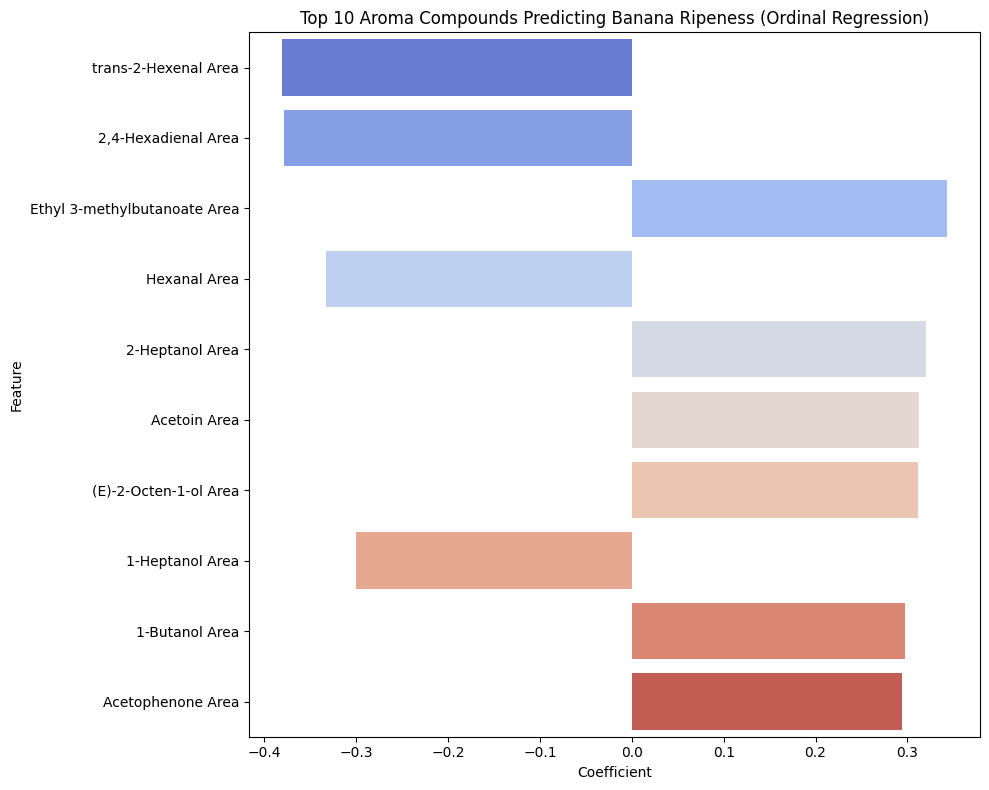

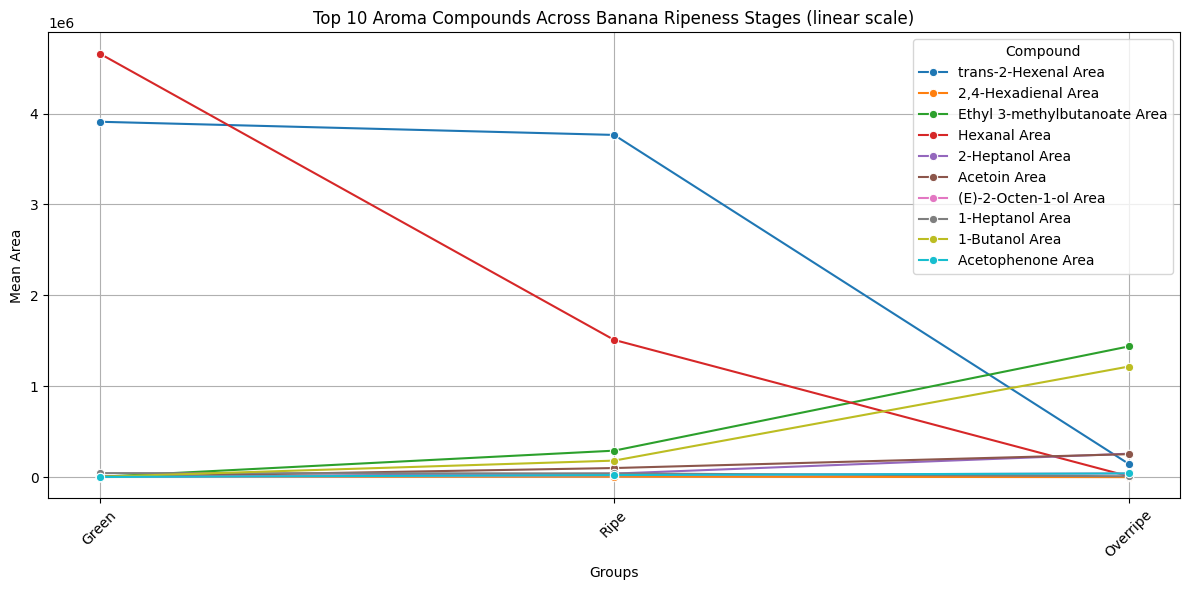

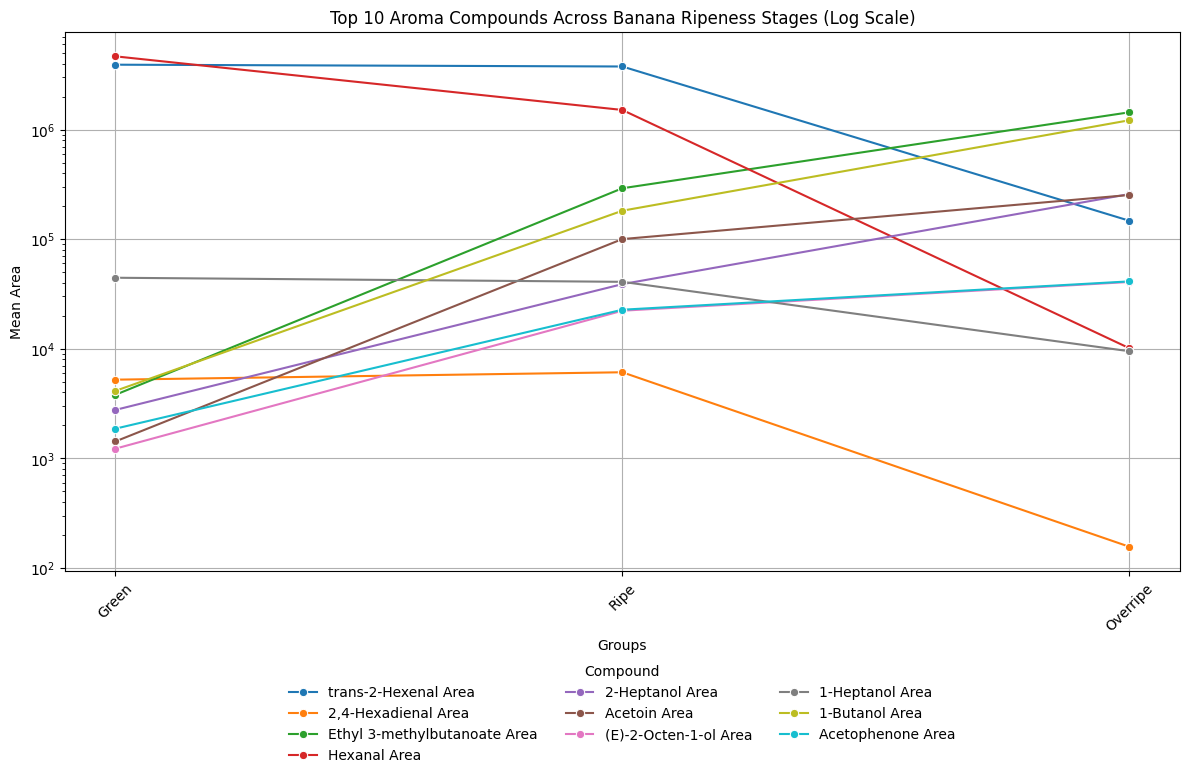

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from mord import LogisticAT  # Ordinal regression model


# parameter: this can be adjusted to show the number of top values to display in figures
top = 10

'''
Choice here between filled data or non-filled 
'''
# Load the dataset (group impute, nans filled with pseudocount)
#df = pd.read_csv("badata_imputed_filled.csv")

df = pd.read_csv('badata_imputed.csv') #this one imputes median of category per column if available but has many NaNs
'''
pick the preproces file above carefully
'''


# Drop the first unnamed column as it's an index
df = df.drop(columns=[df.columns[0]])

# Identify and drop columns with any missing values
missing_cols = df.columns[df.isna().any()].tolist()
print(f"\nDropped columns due to missing values ({len(missing_cols)}):")
for col in missing_cols:
    print(f" - {col}")

df = df.drop(columns=missing_cols)

# Separate features and target
target = df['Groups']
features = df.drop(columns=['Groups'])

# Encode the target as ordinal: Green < Ripe < Overripe
ordinal_map = {'Green': 0, 'Ripe': 1, 'Overripe': 2}
y = target.map(ordinal_map).values

#log features
X_log = np.log10(features)

# scale values
scaler = MinMaxScaler()
X = scaler.fit_transform(X_log)


# Fit ordinal regression model
model = LogisticAT()
model.fit(X, y)

# Get feature coefficients
coefficients = model.coef_
feature_names = features.columns
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values(by='Abs_Coefficient', ascending=False)

# Plot top contributing features
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(top), palette='coolwarm')
plt.title(f'Top {top} Aroma Compounds Predicting Banana Ripeness (Ordinal Regression)')
plt.tight_layout()
#plt.savefig("ordinal_top_features.png")
plt.show()



# Select top contributing features
top_features = coef_df.head(top)['Feature'].values

# Calculate mean values of top features grouped by ripeness
# reset index here ensures the y axis values are in original abundance space
grouped_means = df.groupby('Groups')[top_features].mean().reset_index()

# Melt the dataframe for plotting
melted_df = grouped_means.melt(id_vars='Groups', var_name='Compound', value_name='Mean Area')
# Ensure Groups are in the correct ordinal order
melted_df['Groups'] = pd.Categorical(melted_df['Groups'], categories=['Green', 'Ripe', 'Overripe'], ordered=True)

# Plot lineplot showing how compound levels change across ripeness stages
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (linear scale)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
#plt.savefig("top_compounds_lineplot.png")
plt.show()

# 2nd plot with log scale as data is compressed at bottom
plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='Groups', y='Mean Area', hue='Compound', marker='o')
plt.yscale('log')
plt.title(f'Top {top} Aroma Compounds Across Banana Ripeness Stages (Log Scale)')
plt.xticks(rotation=45)
plt.grid(True)
#plt.legend([],[], frameon=False)  # removes the legend
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # center it below the plot
    ncol=3,                       # number of columns (adjust as needed)
    title="Compound",
    frameon=False
)
plt.tight_layout()
#plt.savefig("top_compounds_lineplot(log).png")
plt.show()

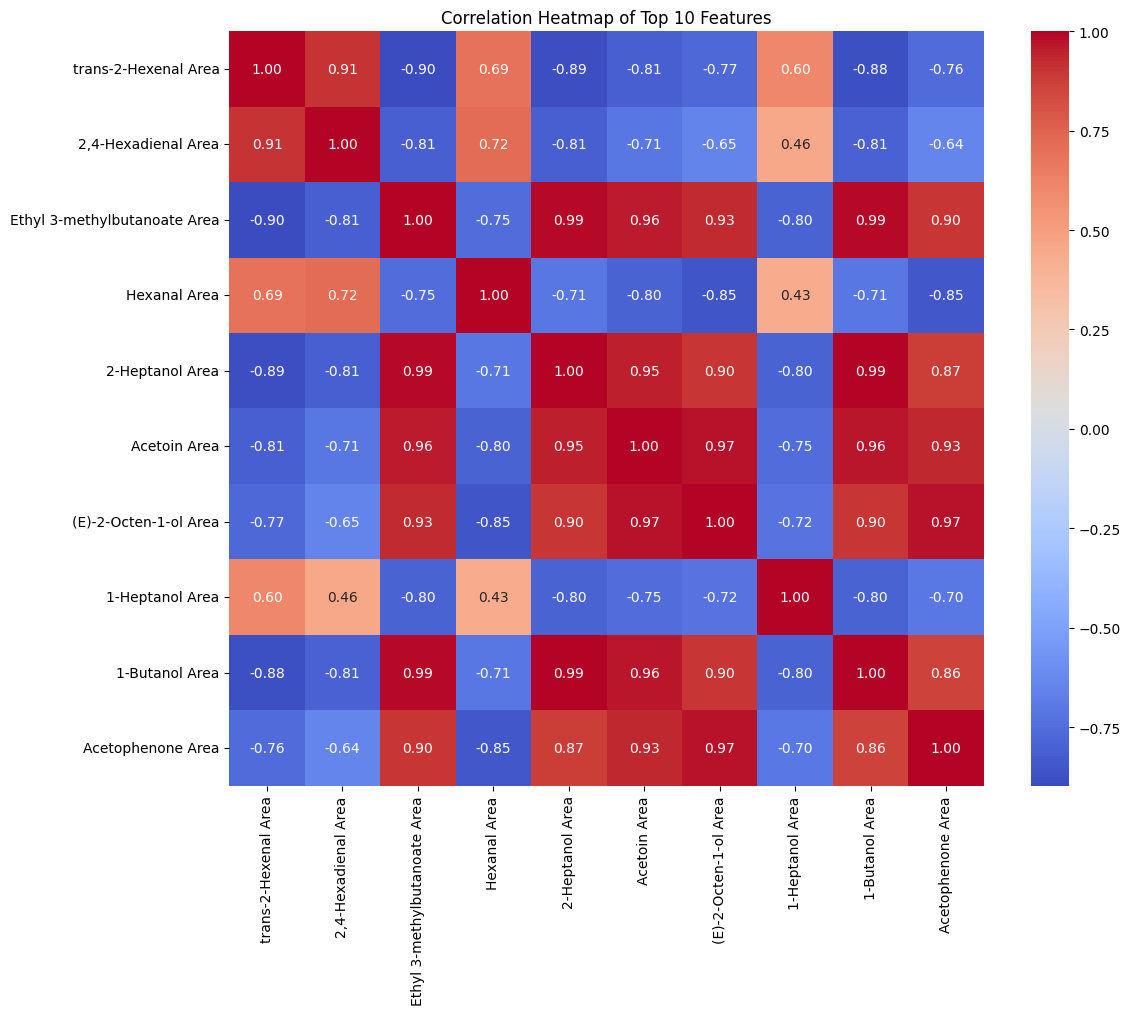

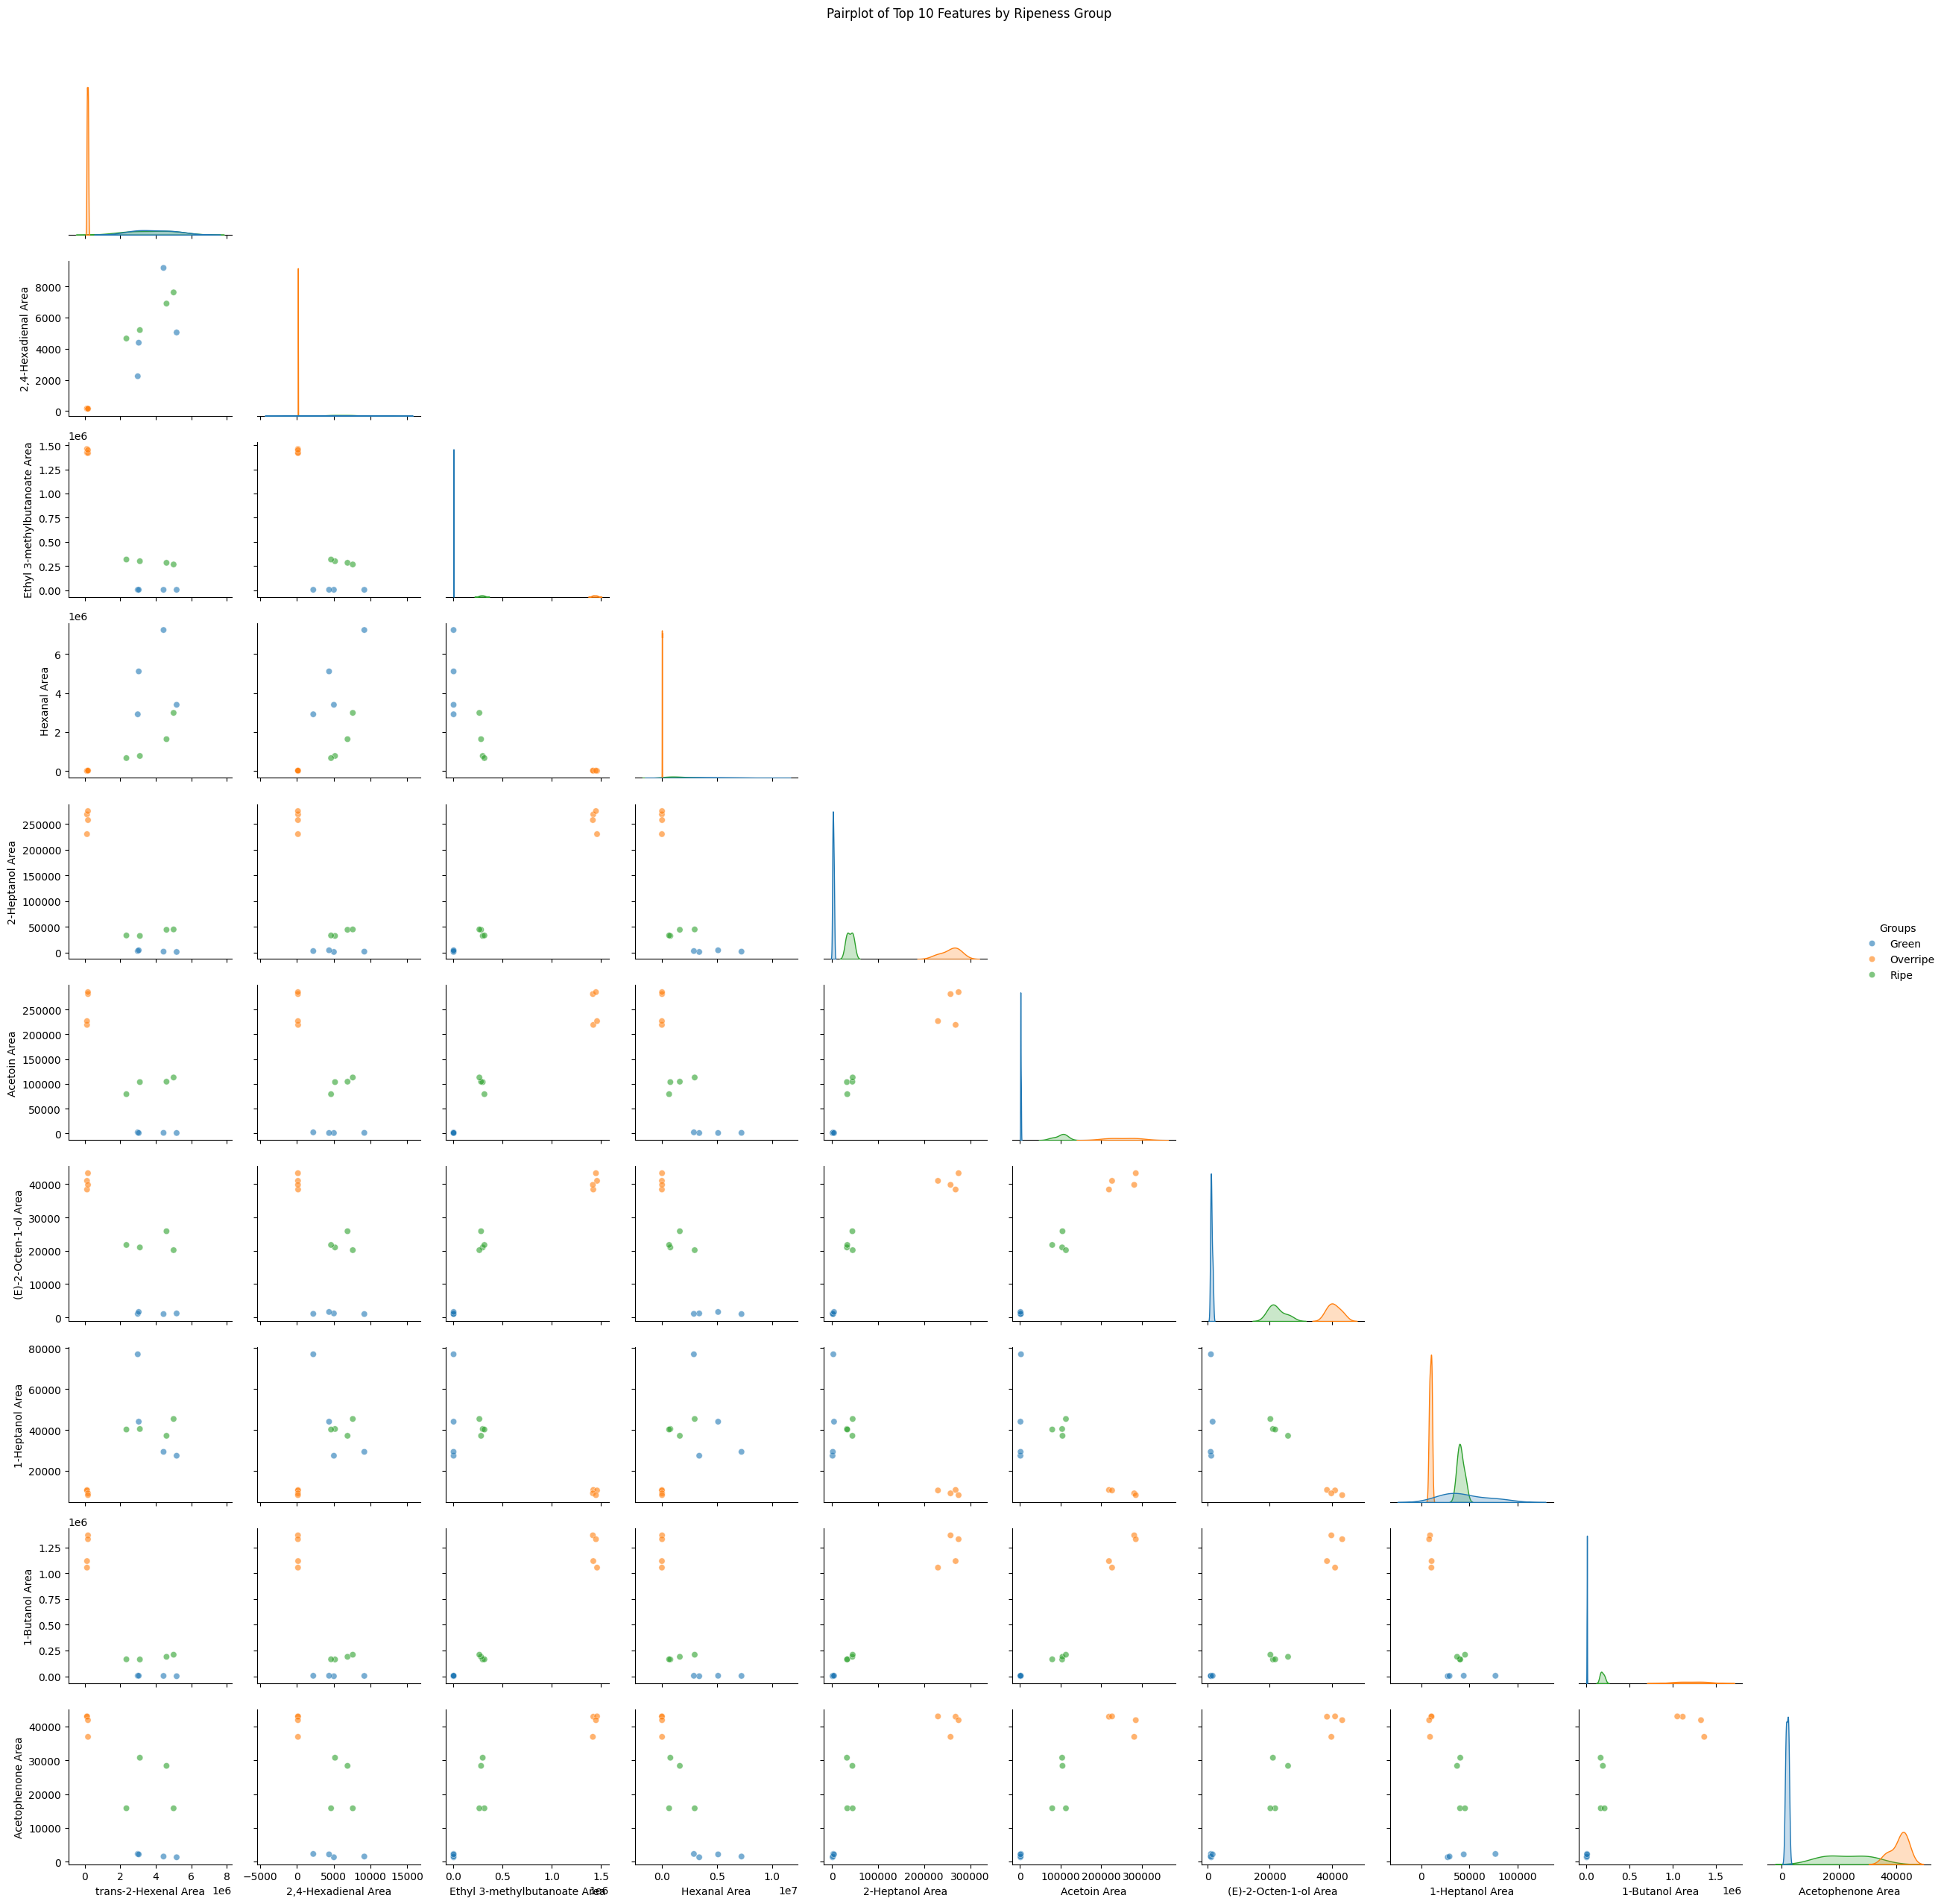

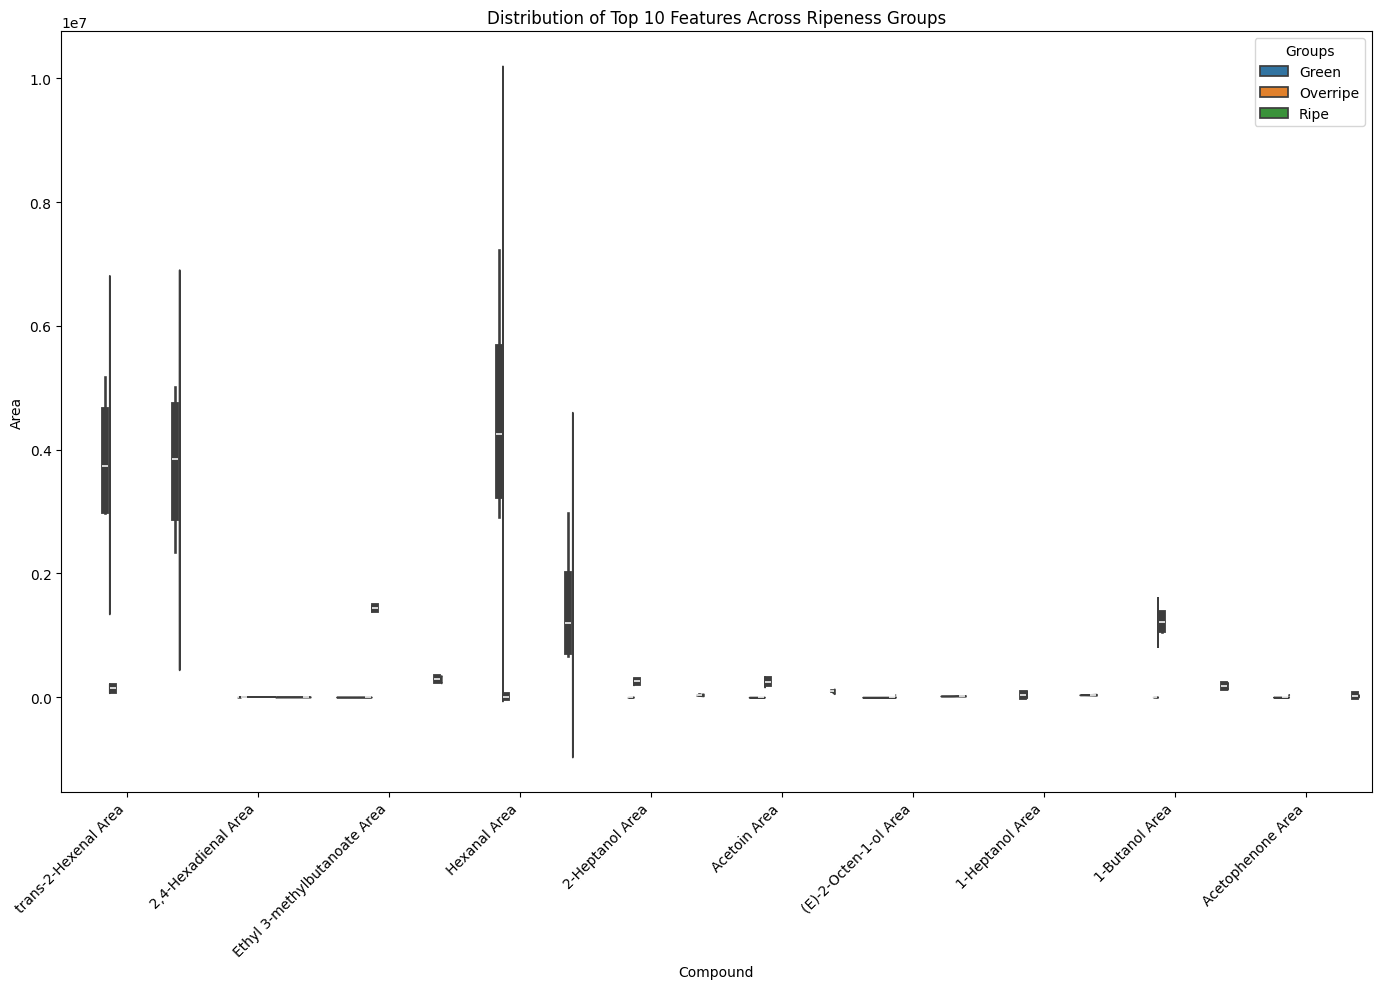

In [2]:
# -----------------------------
# 1. Correlation Heatmap of Top Features
# -----------------------------
plt.figure(figsize=(12, 10))
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlation Heatmap of Top {top} Features')
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Pairplot of Top Features Colored by Ripeness
# -----------------------------
pairplot_df = df[top_features.tolist() + ['Groups']].copy()
sns.pairplot(pairplot_df, hue='Groups', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle(f'Pairplot of Top {top} Features by Ripeness Group', y=1.02)
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Violin Plots of Top Features Across Ripeness Groups
# -----------------------------
melted_violin = df.melt(id_vars='Groups', value_vars=top_features, var_name='Compound', value_name='Area')
plt.figure(figsize=(14, 10))
sns.violinplot(data=melted_violin, x='Compound', y='Area', hue='Groups', split=True)
plt.xticks(rotation=45, ha='right')
plt.title(f'Distribution of Top {top} Features Across Ripeness Groups')
plt.tight_layout()
plt.show()
